
=== Logical AND Fusion ===

--- Training on Text ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.960     0.981     0.970      1826
           1      0.930     0.863     0.895       540

    accuracy                          0.954      2366
   macro avg      0.945     0.922     0.933      2366
weighted avg      0.953     0.954     0.953      2366

Accuracy : 0.9539
Precision: 0.9301
Recall   : 0.8630
F1 Score : 0.8953
AUC      : 0.9219


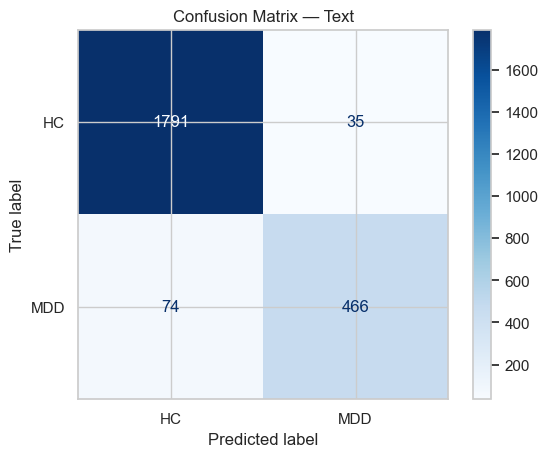

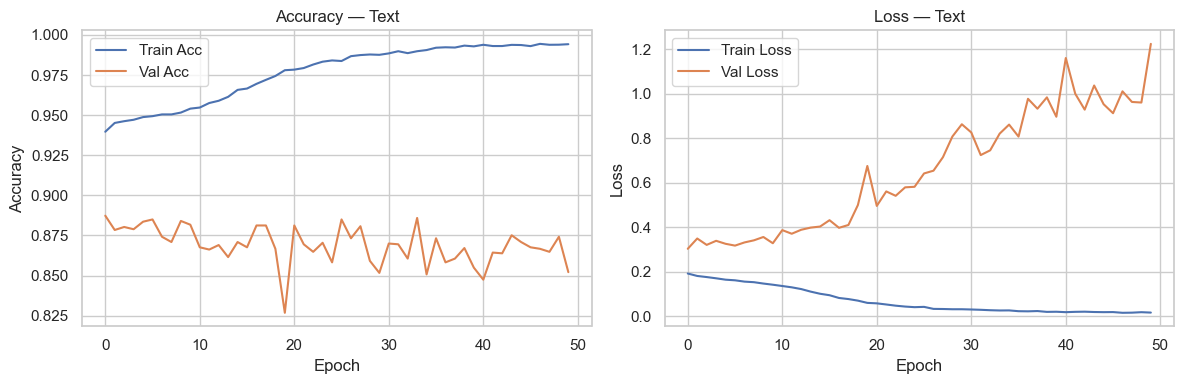

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

--- Training on Audio ---
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.934     0.973     0.953      1826
           1      0.894     0.767     0.826       540

    accuracy                          0.926      2366
   macro avg      0.914     0.870     0.889      2366
weighted avg      0.925     0.926     0.924      2366

Accuracy : 0.9260
Precision: 0.8942
Recall   : 0.7667
F1 Score : 0.8255
AUC      : 0.8699


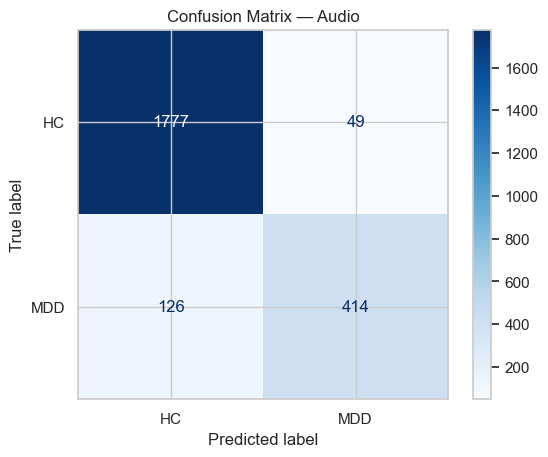

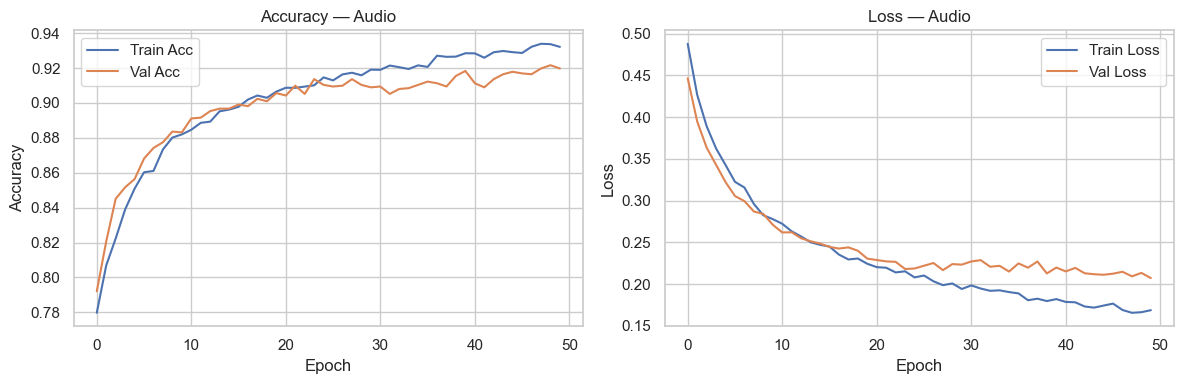

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

🧠 AND-Fused Classification Report:
              precision    recall  f1-score   support

           0      0.911     1.000     0.953      1826
           1      1.000     0.669     0.801       540

    accuracy                          0.924      2366
   macro avg      0.955     0.834     0.877      2366
weighted avg      0.931     0.924     0.919      2366

Accuracy : 0.9243
Precision: 1.0000
Recall   : 0.6685
F1 Score : 0.8013
AUC      : 0.8343


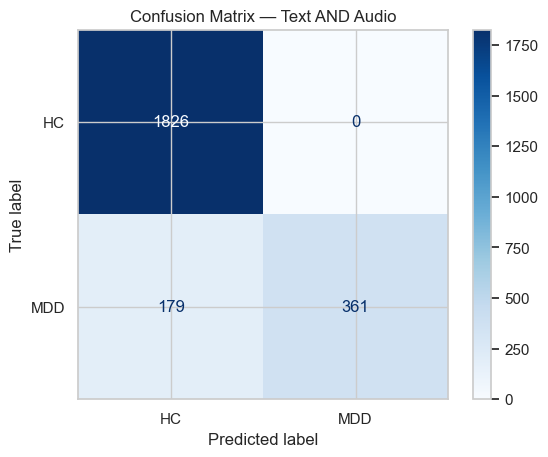


📊 Final Results Summary:
                Accuracy  Precision  Recall  F1 Score     AUC
Modality                                                     
Text              0.9539     0.9301  0.8630    0.8953  0.9219
Audio             0.9260     0.8942  0.7667    0.8255  0.8699
Text AND Audio    0.9243     1.0000  0.6685    0.8013  0.8343


In [13]:
#AND
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # ✅ Force CPU only

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input  # ✅ Input added
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Adam

sns.set(style="whitegrid")

# Create output directory
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Load data
bert = np.load("Data_edaic/bert_embeddings_04sec.npy")
acoustic = np.load("Data_edaic/acoustic_scaled_56_04sec.npy")
labels = np.load("Data_edaic/labels_04sec.npy")

# Initialize result list
results = []

# DNN for audio 
def build_dnn_model(input_shape):
    return Sequential([
        Input(shape=input_shape),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

# 1DCNN for text
def build_1dcnn_model(input_shape):
    return Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

def plot_history(history, modality_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"Accuracy — {modality_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Loss — {modality_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{output_dir}/history_{modality_name.replace('+','_')}.png")
    plt.show()

def print_class_counts(name, y):
    c = Counter(y)
    print(f"{name} — HC: {c[0]}, MDD: {c[1]}")

def evaluate_model(X, y, modality_name, model_builder, reshape=False):
    print(f"\n--- Training on {modality_name} ---")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    val_size = int(0.2 * len(X_train))
    y_train_final = y_train[:-val_size]
    y_val = y_train[-val_size:]

    if reshape:
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = model_builder(X_train.shape[1:])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=50, batch_size=32,
        verbose=0
    )

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {modality_name}")
    plt.savefig(f"{output_dir}/conf_matrix_{modality_name.replace('+','_')}.png")
    plt.show()

    plot_history(history, modality_name)

    print_class_counts("Train", y_train_final)
    print_class_counts("Val", y_val)
    print_class_counts("Test", y_test)

    results.append({
        "Modality": modality_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc
    })

    return model, X_test, y_test

def evaluate_and_fusion():
    print("\n=== Logical AND Fusion ===")
    model_text, X_text_test, y_test = evaluate_model(bert, labels, "Text", build_1dcnn_model, reshape=True)
    model_audio, X_audio_test, _ = evaluate_model(acoustic, labels, "Audio", build_dnn_model, reshape=False)

    pred_text = (model_text.predict(X_text_test) > 0.5).astype(int).flatten()
    pred_audio = (model_audio.predict(X_audio_test) > 0.5).astype(int).flatten()

    y_pred_and = np.logical_and(pred_text, pred_audio).astype(int)

    acc = accuracy_score(y_test, y_pred_and)
    prec = precision_score(y_test, y_pred_and)
    rec = recall_score(y_test, y_pred_and)
    f1 = f1_score(y_test, y_pred_and)
    auc = roc_auc_score(y_test, y_pred_and)

    print("\n🧠 AND-Fused Classification Report:")
    print(classification_report(y_test, y_pred_and, digits=3))
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred_and)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix — Text AND Audio")
    plt.savefig(f"{output_dir}/conf_matrix_AND.png")
    plt.show()

    results.append({
        "Modality": "Text AND Audio",
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc
    })

# Run
evaluate_and_fusion()

# Summary
df_results = pd.DataFrame(results).set_index("Modality").round(4)
print("\n📊 Final Results Summary:")
print(df_results)



=== Logical AND Fusion ===

--- Training on Text ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.962     0.981     0.971      1826
           1      0.931     0.869     0.898       540

    accuracy                          0.955      2366
   macro avg      0.946     0.925     0.935      2366
weighted avg      0.955     0.955     0.955      2366

Accuracy : 0.9552
Precision: 0.9306
Recall   : 0.8685
F1 Score : 0.8985
AUC      : 0.9247


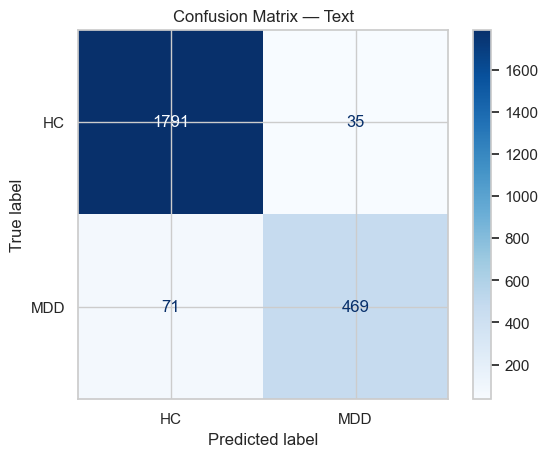

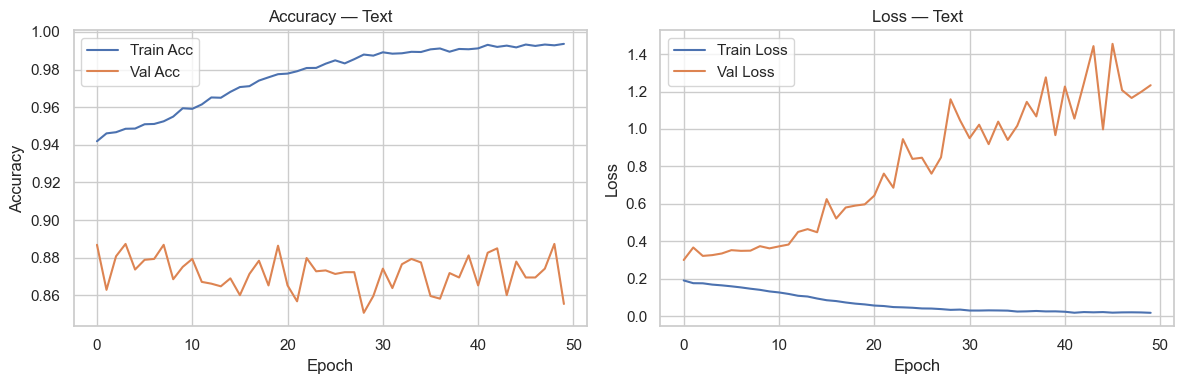

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

--- Training on Audio ---
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.936     0.963     0.949      1826
           1      0.861     0.778     0.817       540

    accuracy                          0.921      2366
   macro avg      0.898     0.870     0.883      2366
weighted avg      0.919     0.921     0.919      2366

Accuracy : 0.9205
Precision: 0.8607
Recall   : 0.7778
F1 Score : 0.8171
AUC      : 0.8703


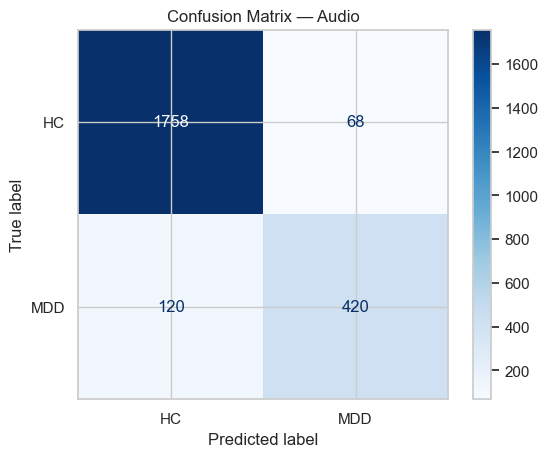

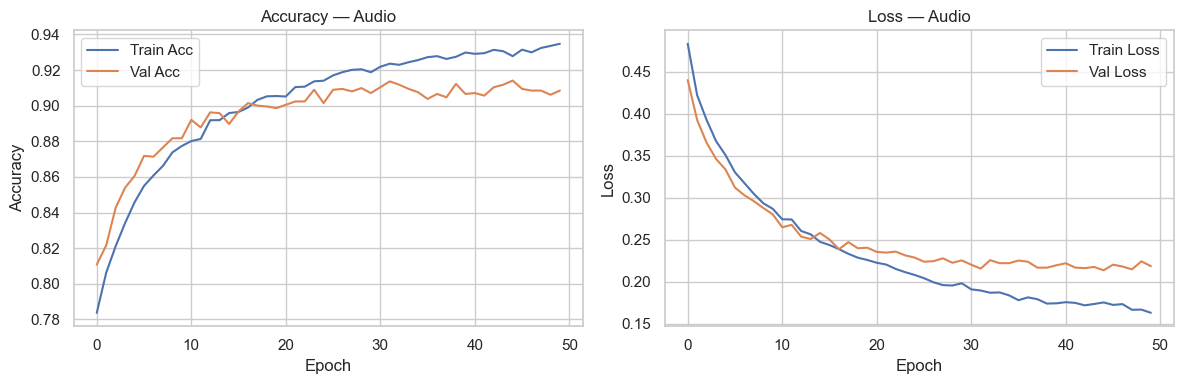

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

🧠 AND-Fused Classification Report:
              precision    recall  f1-score   support

           0      0.988     0.944     0.966      1826
           1      0.836     0.961     0.894       540

    accuracy                          0.948      2366
   macro avg      0.912     0.953     0.930      2366
weighted avg      0.953     0.948     0.949      2366

Accuracy : 0.9480
Precision: 0.8357
Recall   : 0.9611
F1 Score : 0.8941
AUC      : 0.9526


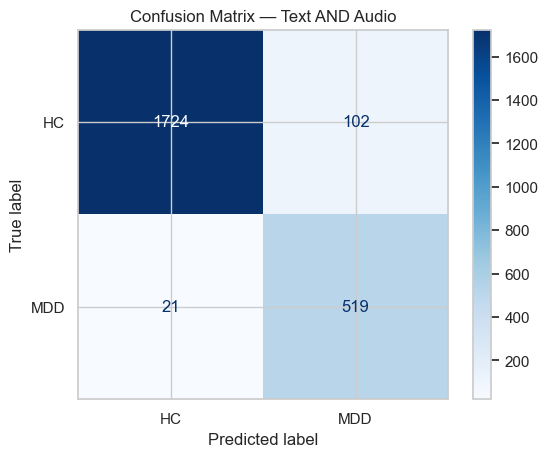


📊 Final Results Summary:
                Accuracy  Precision  Recall  F1 Score     AUC
Modality                                                     
Text              0.9552     0.9306  0.8685    0.8985  0.9247
Audio             0.9205     0.8607  0.7778    0.8171  0.8703
Text AND Audio    0.9480     0.8357  0.9611    0.8941  0.9526


In [6]:
#OR
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # ✅ Force CPU only

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input  # ✅ Input added
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Adam

sns.set(style="whitegrid")

# Create output directory
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Load data
bert = np.load("Data_edaic/bert_embeddings_04sec.npy")
acoustic = np.load("Data_edaic/acoustic_scaled_56_04sec.npy")
labels = np.load("Data_edaic/labels_04sec.npy")

# Initialize result list
results = []

# DNN for audio 
def build_dnn_model(input_shape):
    return Sequential([
        Input(shape=input_shape),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

# 1DCNN for text
def build_1dcnn_model(input_shape):
    return Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

def plot_history(history, modality_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"Accuracy — {modality_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Loss — {modality_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{output_dir}/history_{modality_name.replace('+','_')}.png")
    plt.show()

def print_class_counts(name, y):
    c = Counter(y)
    print(f"{name} — HC: {c[0]}, MDD: {c[1]}")

def evaluate_model(X, y, modality_name, model_builder, reshape=False):
    print(f"\n--- Training on {modality_name} ---")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    val_size = int(0.2 * len(X_train))
    y_train_final = y_train[:-val_size]
    y_val = y_train[-val_size:]

    if reshape:
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = model_builder(X_train.shape[1:])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=50, batch_size=32,
        verbose=0
    )

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {modality_name}")
    plt.savefig(f"{output_dir}/conf_matrix_{modality_name.replace('+','_')}.png")
    plt.show()

    plot_history(history, modality_name)

    print_class_counts("Train", y_train_final)
    print_class_counts("Val", y_val)
    print_class_counts("Test", y_test)

    results.append({
        "Modality": modality_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc
    })

    return model, X_test, y_test

def evaluate_and_fusion():
    print("\n=== Logical AND Fusion ===")
    model_text, X_text_test, y_test = evaluate_model(bert, labels, "Text", build_1dcnn_model, reshape=True)
    model_audio, X_audio_test, _ = evaluate_model(acoustic, labels, "Audio", build_dnn_model, reshape=False)

    pred_text = (model_text.predict(X_text_test) > 0.5).astype(int).flatten()
    pred_audio = (model_audio.predict(X_audio_test) > 0.5).astype(int).flatten()

    y_pred_and = np.logical_or(pred_text, pred_audio).astype(int)

    acc = accuracy_score(y_test, y_pred_and)
    prec = precision_score(y_test, y_pred_and)
    rec = recall_score(y_test, y_pred_and)
    f1 = f1_score(y_test, y_pred_and)
    auc = roc_auc_score(y_test, y_pred_and)

    print("\n🧠 AND-Fused Classification Report:")
    print(classification_report(y_test, y_pred_and, digits=3))
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred_and)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix — Text AND Audio")
    plt.savefig(f"{output_dir}/conf_matrix_AND.png")
    plt.show()

    results.append({
        "Modality": "Text AND Audio",
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc
    })

# Run
evaluate_and_fusion()

# Summary
df_results = pd.DataFrame(results).set_index("Modality").round(4)
print("\n📊 Final Results Summary:")
print(df_results)



--- Training on Text ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.960     0.978     0.969      1826
           1      0.921     0.863     0.891       540

    accuracy                          0.952      2366
   macro avg      0.941     0.921     0.930      2366
weighted avg      0.951     0.952     0.951      2366

Accuracy : 0.9518, Precision: 0.9209, Recall: 0.8630, F1: 0.8910, AUC: 0.9205


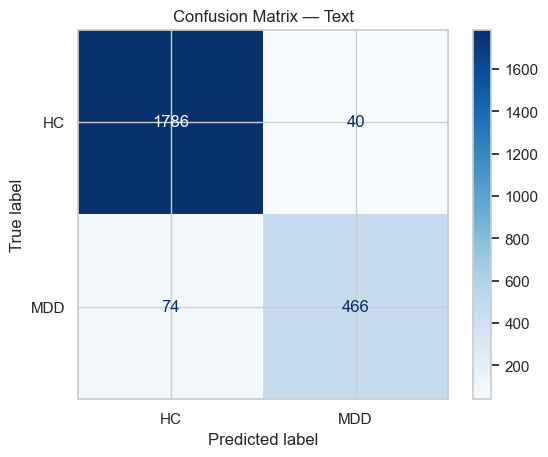

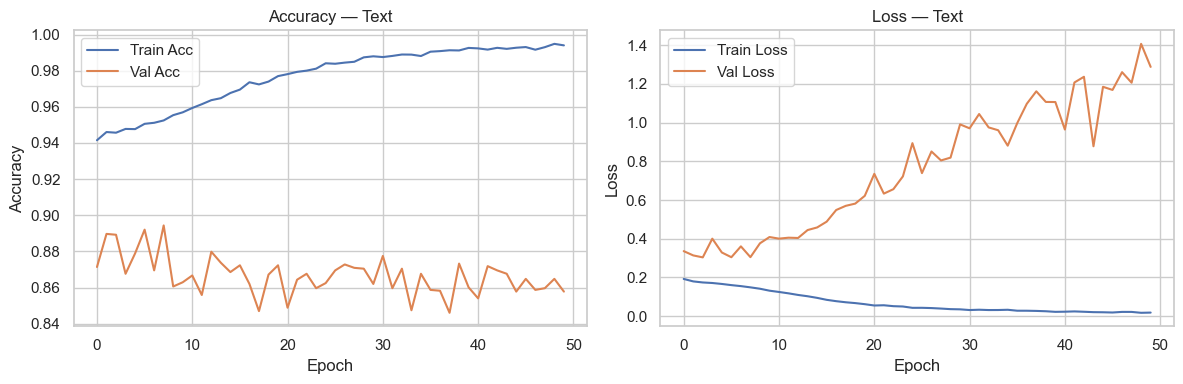

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

--- Training on Audio ---
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

Classification Report:
              precision    recall  f1-score   support

           0      0.931     0.965     0.948      1826
           1      0.867     0.759     0.809       540

    accuracy                          0.918      2366
   macro avg      0.899     0.862     0.879      2366
weighted avg      0.917     0.918     0.916      2366

Accuracy : 0.9184, Precision: 0.8668, Recall: 0.7593, F1: 0.8095, AUC: 0.8624


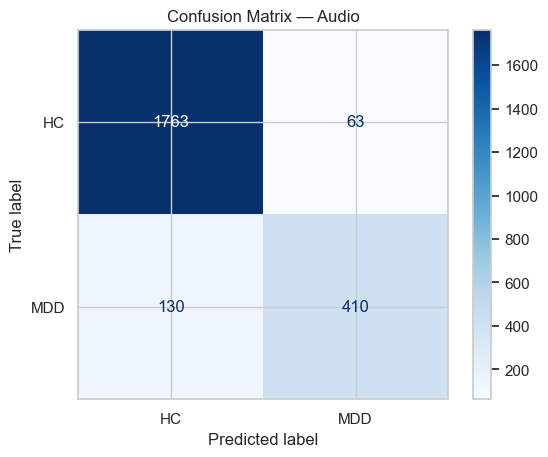

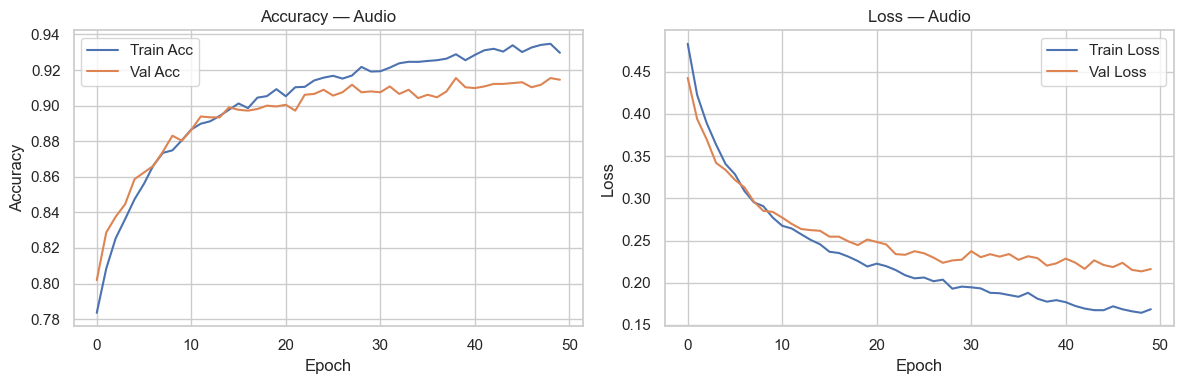

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

=== Fusion Model: Text + Audio ===
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.966     0.986     0.976      1826
           1      0.950     0.881     0.915       540

    accuracy                          0.962      2366
   macro avg      0.958     0.934     0.945      2366
weighted avg      0.962     0.962     0.962      2366

Accuracy : 0.9624, Precision: 0.9501, Recall: 0.8815, F1: 0.9145, AUC: 0.9339


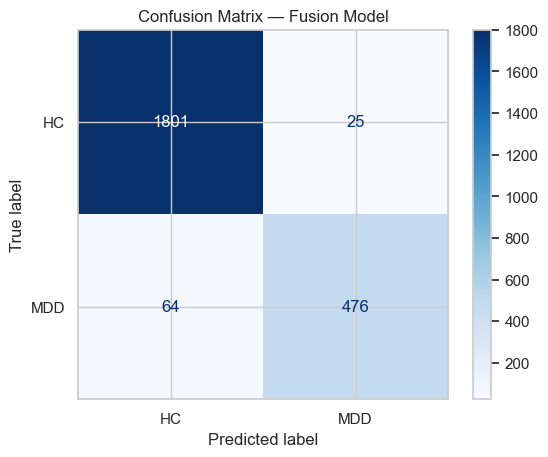

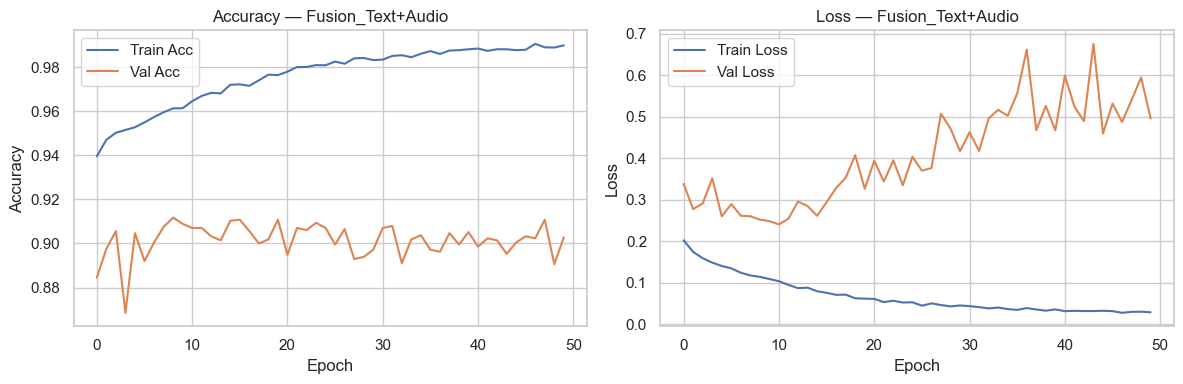

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

📊 Final Results Summary:
                   Accuracy  Precision  Recall  F1 Score     AUC
Modality                                                        
Text                 0.9518     0.9209  0.8630    0.8910  0.9205
Audio                0.9184     0.8668  0.7593    0.8095  0.8624
Text+Audio Fusion    0.9624     0.9501  0.8815    0.9145  0.9339


In [11]:
#Concatination
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # CPU only

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Conv1D, MaxPooling1D, Flatten,
    Input, concatenate
)
from tensorflow.keras.optimizers import Adam

sns.set(style="whitegrid")

# Output directory
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Load data
bert = np.load("Data_edaic/bert_embeddings_04sec.npy")
acoustic = np.load("Data_edaic/acoustic_scaled_56_04sec.npy")
labels = np.load("Data_edaic/labels_04sec.npy")

results = []

# ================================
# Model Builders
# ================================

def build_dnn_model(input_shape):
    return Sequential([
        Input(shape=input_shape),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

def build_1dcnn_model(input_shape):
    return Sequential([
        Conv1D(128, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(),
        Dropout(0.3),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

def build_fusion_model(input_shape_text, input_shape_audio):
    text_input = Input(shape=input_shape_text, name='text_input')
    x_text = Conv1D(128, 3, activation='relu')(text_input)
    x_text = MaxPooling1D()(x_text)
    x_text = Dropout(0.3)(x_text)
    x_text = Conv1D(64, 3, activation='relu')(x_text)
    x_text = MaxPooling1D(pool_size=2)(x_text)
    x_text = Dropout(0.3)(x_text)
    x_text = Flatten()(x_text)

    audio_input = Input(shape=input_shape_audio, name='audio_input')
    x_audio = Dense(128, activation='relu')(audio_input)
    x_audio = Dropout(0.3)(x_audio)
    x_audio = Dense(64, activation='relu')(x_audio)
    x_audio = Dropout(0.3)(x_audio)

    merged = concatenate([x_text, x_audio])
    x = Dense(64, activation='relu')(merged)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    return Model(inputs=[text_input, audio_input], outputs=output)

# ================================
# Utility
# ================================

def plot_history(history, name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"Accuracy — {name}")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Loss — {name}")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.tight_layout()
    plt.savefig(f"{output_dir}/history_{name.replace('+','_')}.png")
    plt.show()

def print_class_counts(name, y):
    c = Counter(y)
    print(f"{name} — HC: {c[0]}, MDD: {c[1]}")

def evaluate_single_model(X, y, modality_name, model_builder, reshape=False):
    print(f"\n--- Training on {modality_name} ---")
    if reshape:
        X = X.reshape((X.shape[0], X.shape[1], 1))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    val_size = int(0.2 * len(X_train))
    y_train_final = y_train[:-val_size]
    y_val = y_train[-val_size:]

    model = model_builder(X_train.shape[1:])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, verbose=0)

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Accuracy : {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {modality_name}")
    plt.savefig(f"{output_dir}/conf_matrix_{modality_name.replace('+','_')}.png")
    plt.show()

    plot_history(history, modality_name)
    print_class_counts("Train", y_train_final)
    print_class_counts("Val", y_val)
    print_class_counts("Test", y_test)

    results.append({
        "Modality": modality_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc
    })

def evaluate_fusion_model(bert, acoustic, labels):
    print("\n=== Fusion Model: Text + Audio ===")
    bert_reshaped = bert.reshape((bert.shape[0], bert.shape[1], 1))

    X_text_train, X_text_test, X_audio_train, X_audio_test, y_train, y_test = train_test_split(
        bert_reshaped, acoustic, labels, test_size=0.1, random_state=42
    )
    val_size = int(0.2 * len(X_text_train))
    y_train_final = y_train[:-val_size]
    y_val = y_train[-val_size:]

    model = build_fusion_model(X_text_train.shape[1:], X_audio_train.shape[1:])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit([X_text_train, X_audio_train], y_train, validation_split=0.1, epochs=50, batch_size=32, verbose=0)

    y_pred_prob = model.predict([X_text_test, X_audio_test])
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Accuracy : {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix — Fusion Model")
    plt.savefig(f"{output_dir}/conf_matrix_fusion.png")
    plt.show()

    plot_history(history, "Fusion_Text+Audio")
    print_class_counts("Train", y_train_final)
    print_class_counts("Val", y_val)
    print_class_counts("Test", y_test)

    results.append({
        "Modality": "Text+Audio Fusion",
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc
    })

# ================================
# Run All
# ================================
evaluate_single_model(bert, labels, "Text", build_1dcnn_model, reshape=True)
evaluate_single_model(acoustic, labels, "Audio", build_dnn_model, reshape=False)
evaluate_fusion_model(bert, acoustic, labels)

# ================================
# Summary Table
# ================================
df_results = pd.DataFrame(results).set_index("Modality").round(4)
print("\n📊 Final Results Summary:")
print(df_results)


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
\nClassification Report — Text:
              precision    recall  f1-score   support

           0      0.959     0.974     0.967      1826
           1      0.908     0.859     0.883       540

    accuracy                          0.948      2366
   macro avg      0.934     0.917     0.925      2366
weighted avg      0.947     0.948     0.948      2366

Accuracy : 0.9480, Precision: 0.9080, Recall: 0.8593, F1: 0.8830, AUC: 0.9168


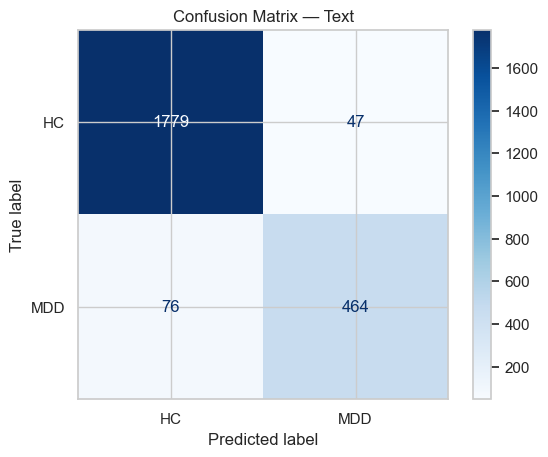

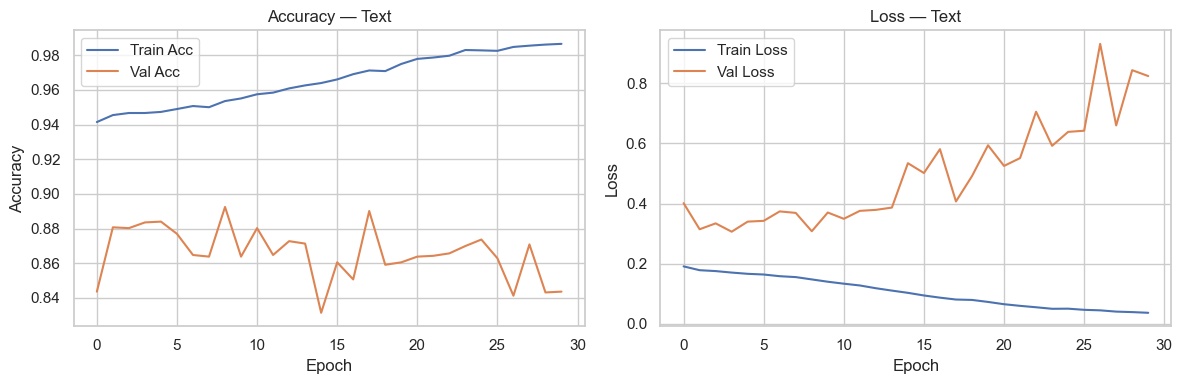

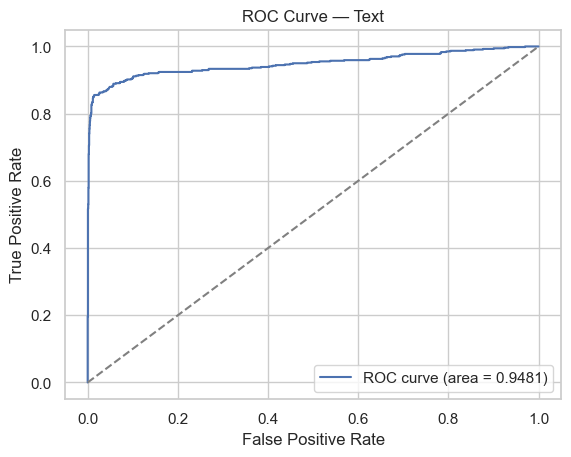

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
\nClassification Report — Audio:
              precision    recall  f1-score   support

           0      0.924     0.969     0.946      1826
           1      0.874     0.730     0.795       540

    accuracy                          0.914      2366
   macro avg      0.899     0.849     0.870      2366
weighted avg      0.912     0.914     0.911      2366

Accuracy : 0.9142, Precision: 0.8736, Recall: 0.7296, F1: 0.7952, AUC: 0.8492


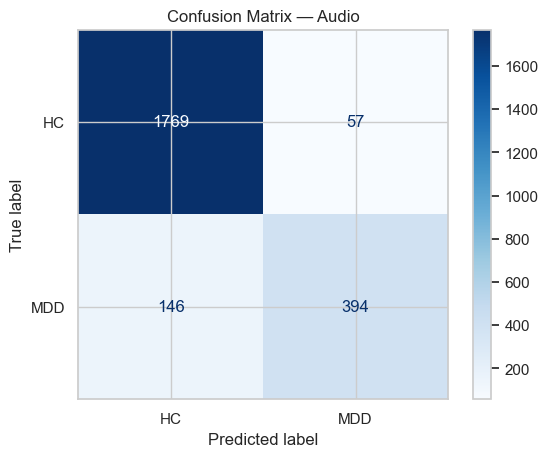

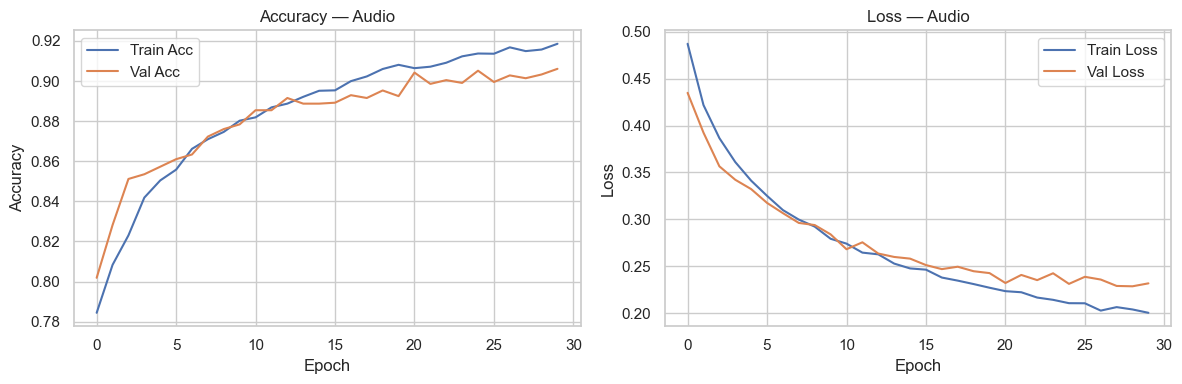

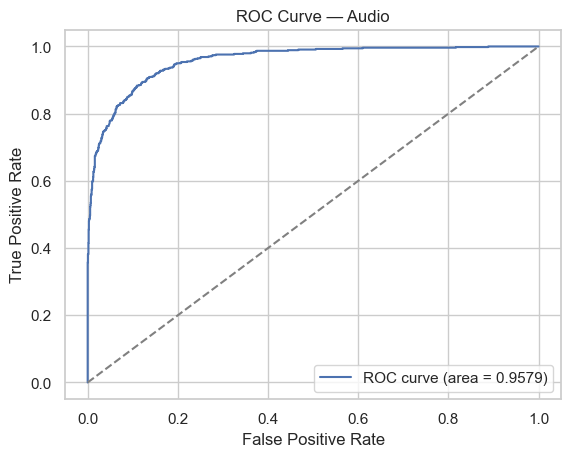

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Classification Report — Text AND Audio:
              precision    recall  f1-score   support

           0      0.902     0.999     0.948      1826
           1      0.997     0.631     0.773       540

    accuracy                          0.915      2366
   macro avg      0.949     0.815     0.861      2366
weighted avg      0.923     0.915     0.908      2366

Accuracy : 0.9155, Precision: 0.9971, Recall: 0.6315, F1: 0.7732, AUC: 0.8155


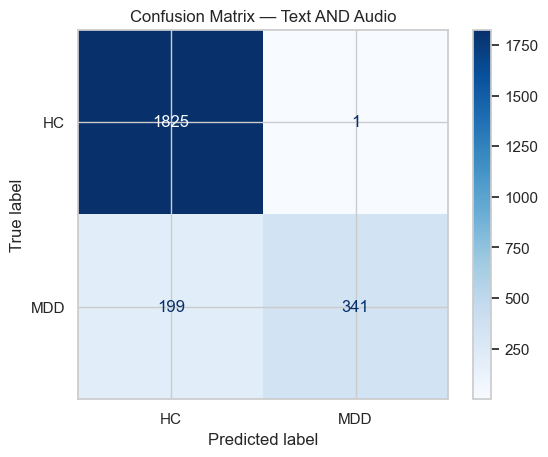

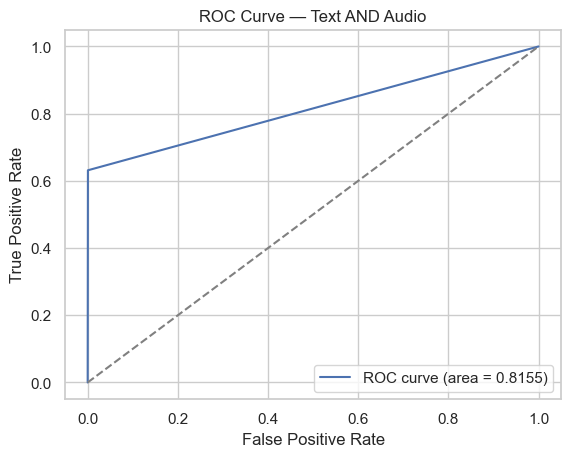


Classification Report — Text OR Audio:
              precision    recall  f1-score   support

           0      0.987     0.944     0.965      1826
           1      0.834     0.957     0.891       540

    accuracy                          0.947      2366
   macro avg      0.910     0.950     0.928      2366
weighted avg      0.952     0.947     0.948      2366

Accuracy : 0.9467, Precision: 0.8339, Recall: 0.9574, F1: 0.8914, AUC: 0.9505


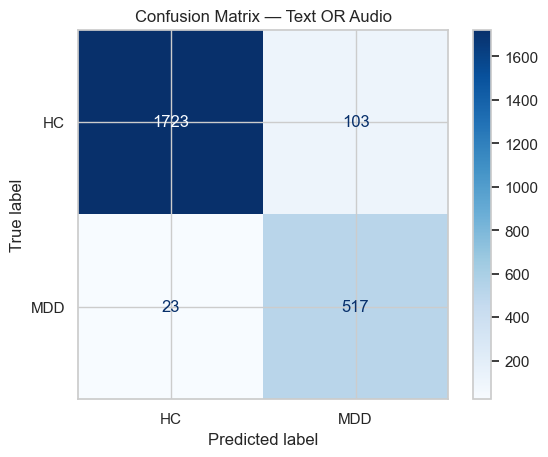

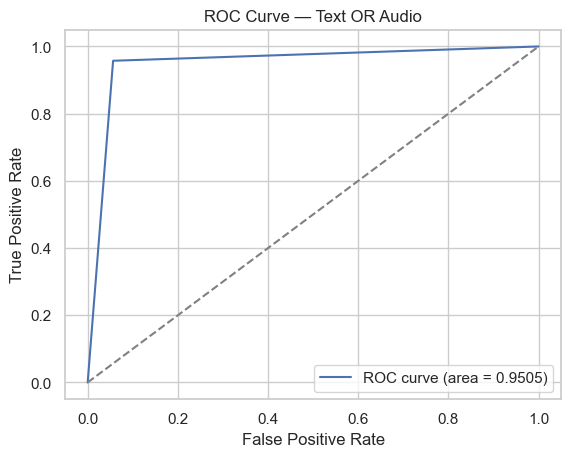

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
\nClassification Report — Text+Audio Fusion:
              precision    recall  f1-score   support

           0      0.967     0.988     0.977      1826
           1      0.956     0.885     0.919       540

    accuracy                          0.964      2366
   macro avg      0.961     0.937     0.948      2366
weighted avg      0.964     0.964     0.964      2366

Accuracy : 0.9645, Precision: 0.9560, Recall: 0.8852, F1: 0.9192, AUC: 0.9366


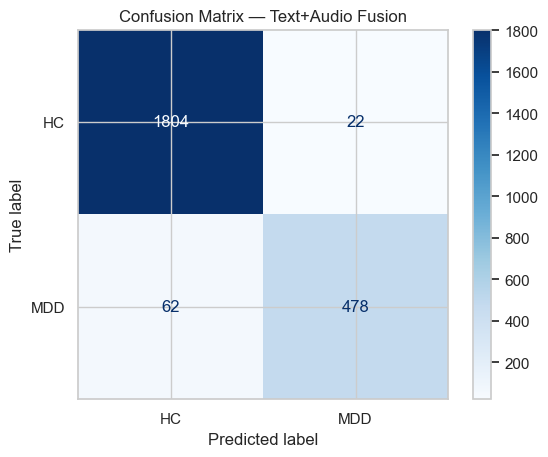

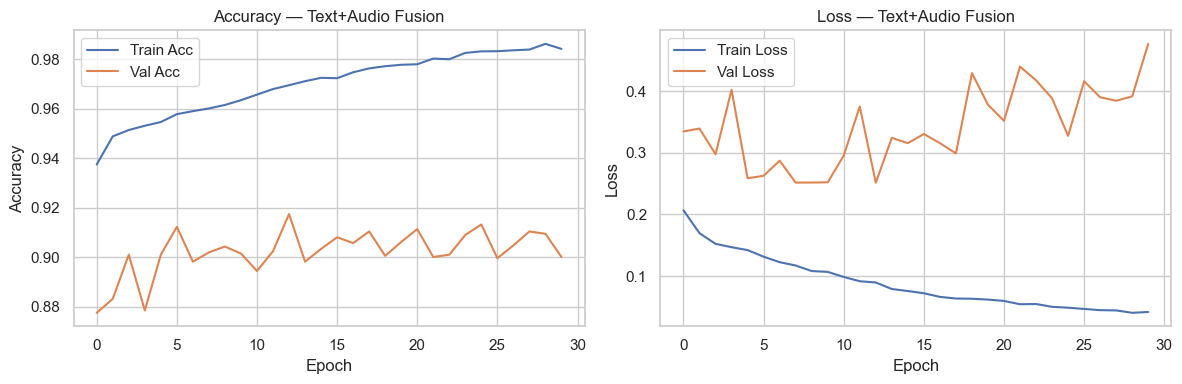

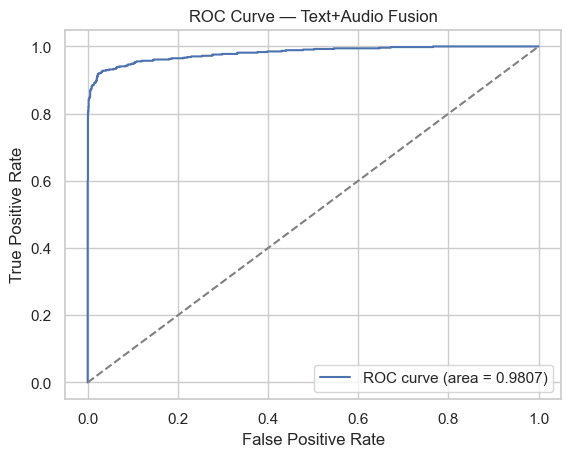

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540
\n📊 Final Results Summary:
                   Accuracy  Precision  Recall  F1 Score     AUC
Modality                                                        
Text                 0.9480     0.9080  0.8593    0.8830  0.9168
Audio                0.9142     0.8736  0.7296    0.7952  0.8492
Text AND Audio       0.9155     0.9971  0.6315    0.7732  0.8155
Text OR Audio        0.9467     0.8339  0.9574    0.8914  0.9505
Text+Audio Fusion    0.9645     0.9560  0.8852    0.9192  0.9366


In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, concatenate
from tensorflow.keras.optimizers import Adam

sns.set(style="whitegrid")
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# ================== Load Data ==================
bert = np.load("Data_edaic/bert_embeddings_04sec.npy")
acoustic = np.load("Data_edaic/acoustic_scaled_56_04sec.npy")
labels = np.load("Data_edaic/labels_04sec.npy")

results = []

# ================== Plot Functions ==================
def plot_history(history, name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"Accuracy — {name}")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Loss — {name}")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.tight_layout()
    plt.savefig(f"{output_dir}/history_{name.replace('+','_')}.png")
    plt.show()

def evaluate_model(name, model, X_test, y_test, history, y_train, y_val, y_train_final, is_fusion=False, fusion_inputs=None):
    if is_fusion:
        y_pred_prob = model.predict(fusion_inputs)
    else:
        y_pred_prob = model.predict(X_test)

    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_pred)

    print(f"\\nClassification Report — {name}:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Accuracy : {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc_val:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.savefig(f"{output_dir}/conf_matrix_{name.replace('+','_')}.png")
    plt.show()

    plot_history(history, name)

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve — {name}")
    plt.legend(loc="lower right")
    plt.savefig(f"{output_dir}/roc_{name.replace('+','_')}.png")
    plt.show()

    results.append({
        "Modality": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc_val
    })

    def print_class_counts(label, y):
        c = Counter(y)
        print(f"{label} — HC: {c[0]}, MDD: {c[1]}")
    
    print_class_counts("Train", y_train_final)
    print_class_counts("Val", y_val)
    print_class_counts("Test", y_test)

# ================== Model Builders ==================
def build_dnn_model(input_shape):
    return Sequential([
        Input(shape=input_shape),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

def build_1dcnn_model(input_shape):
    return Sequential([
        Conv1D(128, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(),
        Dropout(0.3),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

def build_fusion_model(input_shape_text, input_shape_audio):
    text_input = Input(shape=input_shape_text)
    x_text = Conv1D(128, 3, activation='relu')(text_input)
    x_text = MaxPooling1D()(x_text)
    x_text = Dropout(0.3)(x_text)
    x_text = Conv1D(64, 3, activation='relu')(x_text)
    x_text = MaxPooling1D(pool_size=2)(x_text)
    x_text = Dropout(0.3)(x_text)
    x_text = Flatten()(x_text)

    audio_input = Input(shape=input_shape_audio)
    x_audio = Dense(128, activation='relu')(audio_input)
    x_audio = Dropout(0.3)(x_audio)
    x_audio = Dense(64, activation='relu')(x_audio)
    x_audio = Dropout(0.3)(x_audio)

    merged = concatenate([x_text, x_audio])
    x = Dense(64, activation='relu')(merged)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    return Model(inputs=[text_input, audio_input], outputs=output)

# ================== Train-Test Split ==================
bert_reshaped = bert.reshape((bert.shape[0], bert.shape[1], 1))
X_text_train, X_text_test, X_audio_train, X_audio_test, y_train, y_test = train_test_split(
    bert_reshaped, acoustic, labels, test_size=0.1, random_state=42
)
val_size = int(0.2 * len(X_text_train))
y_train_final = y_train[:-val_size]
y_val = y_train[-val_size:]

# ================== Individual Modalities ==================
model_text = build_1dcnn_model(X_text_train.shape[1:])
model_text.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_text = model_text.fit(X_text_train, y_train, validation_split=0.1, epochs=30, batch_size=32, verbose=0)
evaluate_model("Text", model_text, X_text_test, y_test, history_text, y_train, y_val, y_train_final)

model_audio = build_dnn_model(X_audio_train.shape[1:])
model_audio.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_audio = model_audio.fit(X_audio_train, y_train, validation_split=0.1, epochs=30, batch_size=32, verbose=0)
evaluate_model("Audio", model_audio, X_audio_test, y_test, history_audio, y_train, y_val, y_train_final)

# ================== AND / OR Fusion ==================
pred_text = (model_text.predict(X_text_test) > 0.5).astype(int).flatten()
pred_audio = (model_audio.predict(X_audio_test) > 0.5).astype(int).flatten()

for logic_type, fusion_pred in [("AND", np.logical_and(pred_text, pred_audio)), ("OR", np.logical_or(pred_text, pred_audio))]:
    y_pred = fusion_pred.astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_pred)

    print(f"\nClassification Report — Text {logic_type} Audio:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Accuracy : {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc_val:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — Text {logic_type} Audio")
    plt.savefig(f"{output_dir}/conf_matrix_{logic_type}.png")
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve — Text {logic_type} Audio")
    plt.legend(loc="lower right")
    plt.savefig(f"{output_dir}/roc_{logic_type}.png")
    plt.show()

    results.append({
        "Modality": f"Text {logic_type} Audio",
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc_val
    })

# ================== Concatenation Fusion ==================
model_fusion = build_fusion_model(X_text_train.shape[1:], X_audio_train.shape[1:])
model_fusion.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_fusion = model_fusion.fit([X_text_train, X_audio_train], y_train, validation_split=0.1, epochs=30, batch_size=32, verbose=0)

evaluate_model(
    name="Text+Audio Fusion",
    model=model_fusion,
    X_test=None,
    y_test=y_test,
    history=history_fusion,
    y_train=y_train,
    y_val=y_val,
    y_train_final=y_train_final,
    is_fusion=True,
    fusion_inputs=[X_text_test, X_audio_test]
)

# ================== Summary Table ==================
df_results = pd.DataFrame(results).set_index("Modality").round(4)
print("\\n📊 Final Results Summary:")
print(df_results)




C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report — Text:
              precision    recall  f1-score   support

           0      0.961     0.979     0.970      1826
           1      0.923     0.865     0.893       540

    accuracy                          0.953      2366
   macro avg      0.942     0.922     0.931      2366
weighted avg      0.952     0.953     0.952      2366

Accuracy: 0.9527, Precision: 0.9229, Recall: 0.8648, F1: 0.8929, AUC: 0.9515


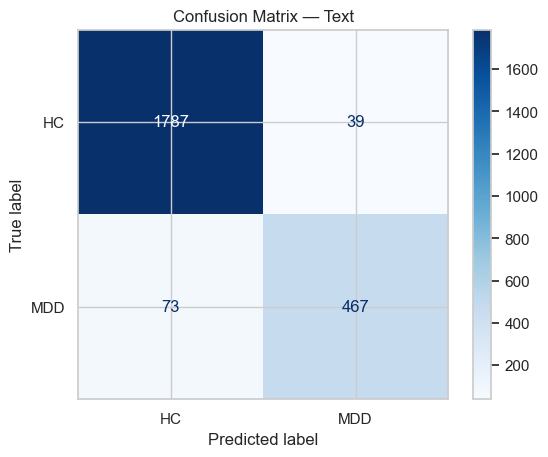

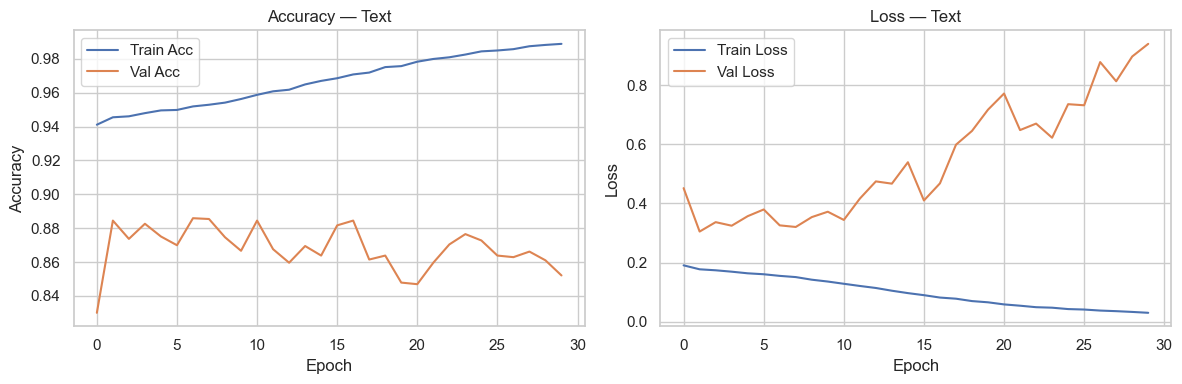

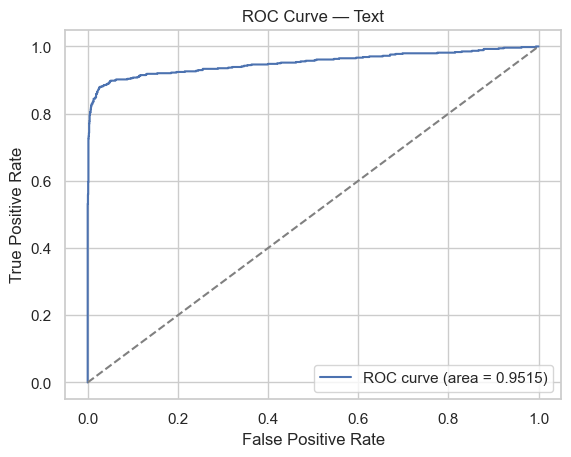

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report — Audio:
              precision    recall  f1-score   support

           0      0.930     0.967     0.948      1826
           1      0.870     0.756     0.809       540

    accuracy                          0.918      2366
   macro avg      0.900     0.861     0.878      2366
weighted avg      0.917     0.918     0.916      2366

Accuracy: 0.9184, Precision: 0.8699, Recall: 0.7556, F1: 0.8087, AUC: 0.9603


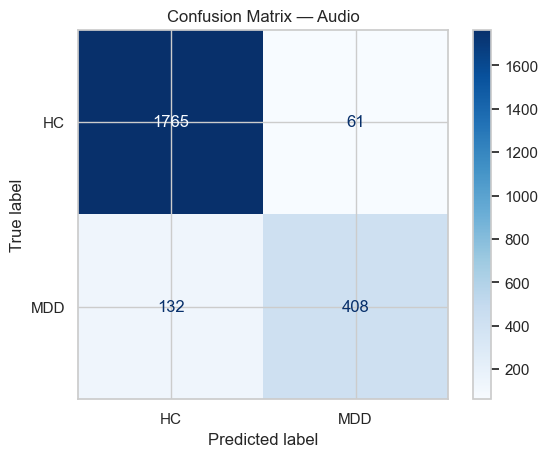

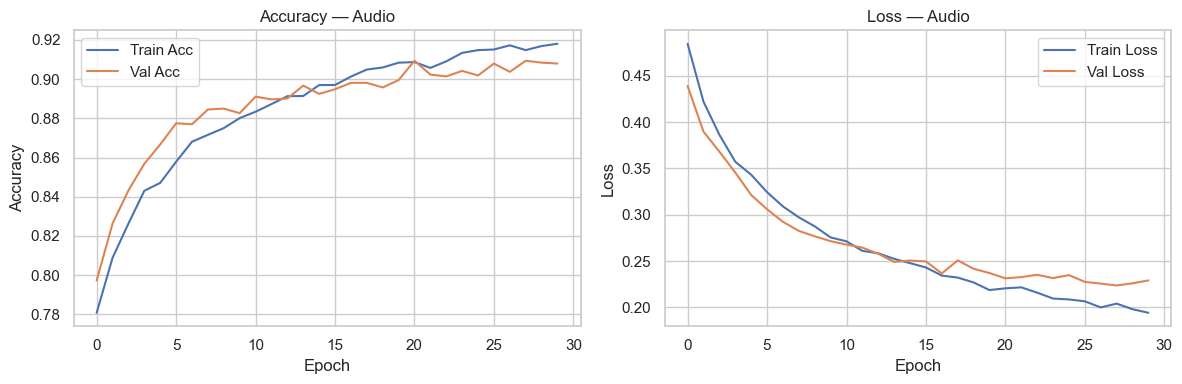

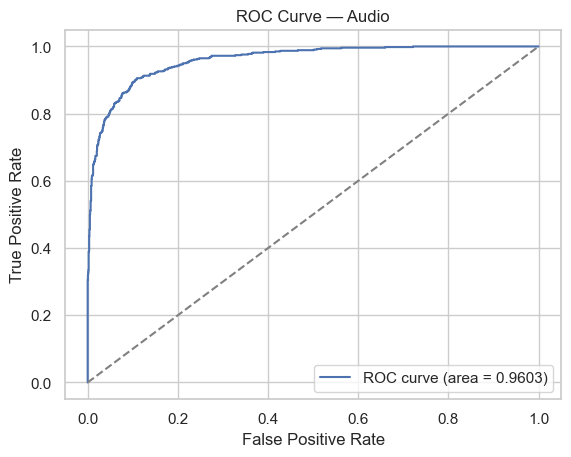

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Classification Report — Text AND Audio:
              precision    recall  f1-score   support

           0      0.907     0.999     0.951      1826
           1      0.997     0.654     0.790       540

    accuracy                          0.921      2366
   macro avg      0.952     0.827     0.870      2366
weighted avg      0.928     0.921     0.914      2366

Accuracy : 0.9205, Precision: 0.9972, Recall: 0.6537, F1: 0.7897, AUC: 0.9533


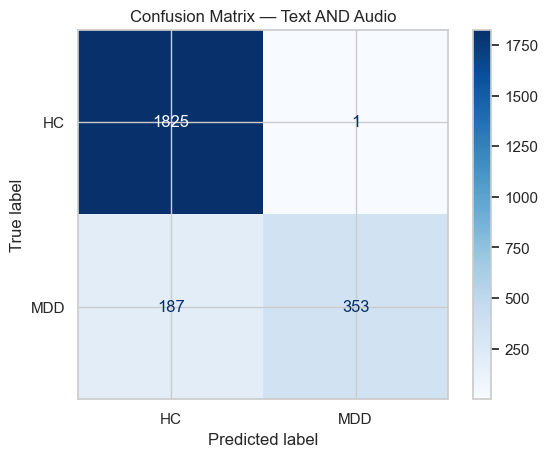

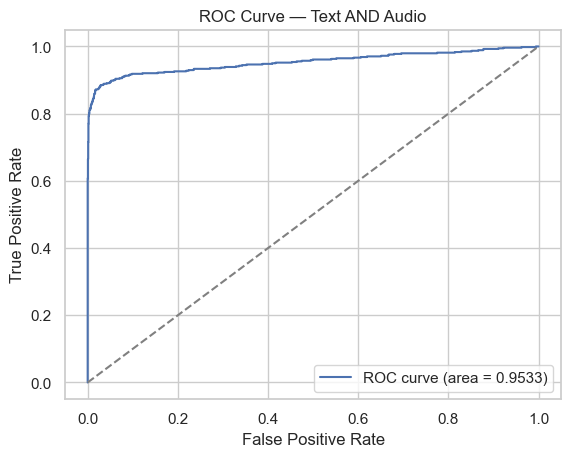


Classification Report — Text OR Audio:
              precision    recall  f1-score   support

           0      0.990     0.946     0.967      1826
           1      0.841     0.967     0.899       540

    accuracy                          0.951      2366
   macro avg      0.915     0.956     0.933      2366
weighted avg      0.956     0.951     0.952      2366

Accuracy : 0.9505, Precision: 0.8406, Recall: 0.9667, F1: 0.8992, AUC: 0.9917


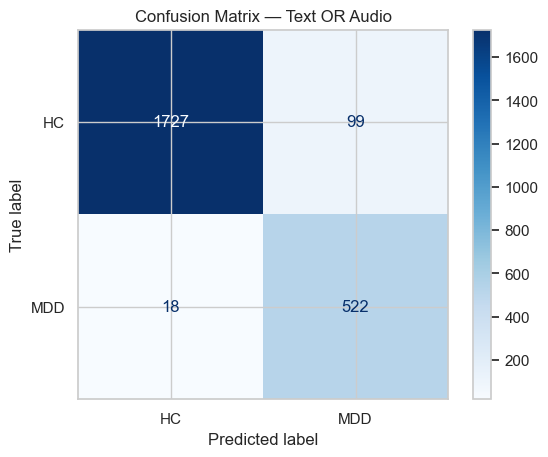

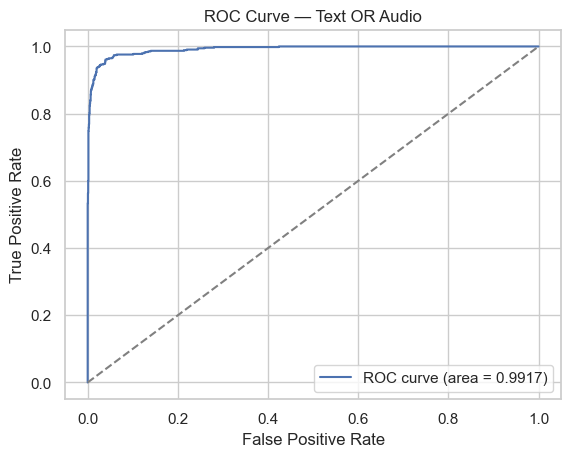

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Classification Report — Text+Audio Fusion:
              precision    recall  f1-score   support

           0      0.970     0.982     0.976      1826
           1      0.936     0.896     0.916       540

    accuracy                          0.962      2366
   macro avg      0.953     0.939     0.946      2366
weighted avg      0.962     0.962     0.962      2366

Accuracy: 0.9624, Precision: 0.9362, Recall: 0.8963, F1: 0.9158, AUC: 0.9834


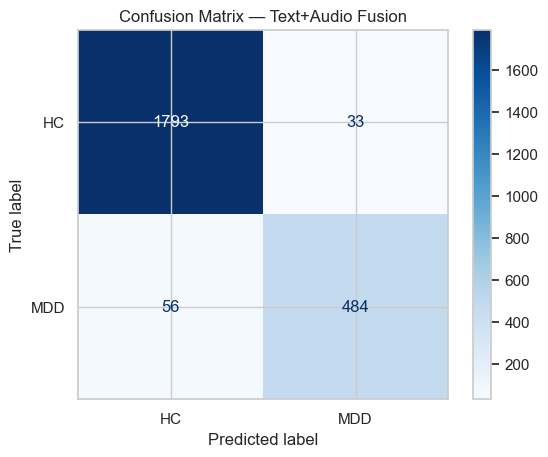

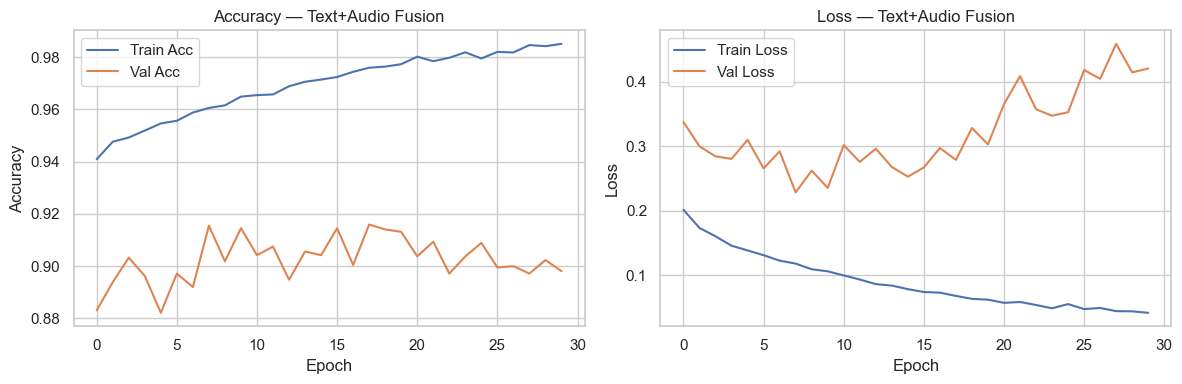

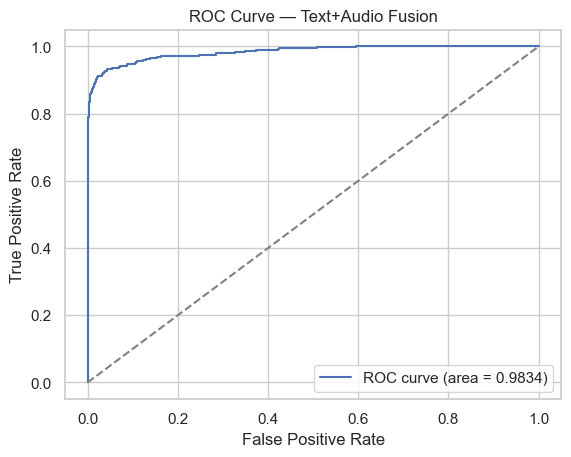


📊 Final Results Summary:
                   Accuracy  Precision  Recall  F1 Score     AUC
Modality                                                        
Text                 0.9527     0.9229  0.8648    0.8929  0.9515
Audio                0.9184     0.8699  0.7556    0.8087  0.9603
Text AND Audio       0.9205     0.9972  0.6537    0.7897  0.9533
Text OR Audio        0.9505     0.8406  0.9667    0.8992  0.9917
Text+Audio Fusion    0.9624     0.9362  0.8963    0.9158  0.9834


In [19]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU if needed

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, concatenate
from tensorflow.keras.optimizers import Adam

# ================== Config ==================
sns.set(style="whitegrid")
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# ================== Load Data ==================
bert = np.load("Data_edaic/bert_embeddings_04sec.npy")
acoustic = np.load("Data_edaic/acoustic_scaled_56_04sec.npy")
labels = np.load("Data_edaic/labels_04sec.npy")

results = []

# ================== Plot Functions ==================
def plot_history(history, name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"Accuracy — {name}")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Loss — {name}")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.tight_layout()
    plt.savefig(f"{output_dir}/history_{name.replace('+','_')}.png")
    plt.show()

def evaluate_model(name, model, X_test, y_test, history, y_train, y_val, y_train_final, is_fusion=False, fusion_inputs=None):
    y_pred_prob = model.predict(fusion_inputs if is_fusion else X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_pred_prob)

    print(f"\nClassification Report — {name}:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc_val:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.savefig(f"{output_dir}/conf_matrix_{name.replace('+','_')}.png")
    plt.show()

    plot_history(history, name)

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve — {name}")
    plt.legend(loc="lower right")
    plt.savefig(f"{output_dir}/roc_{name.replace('+','_')}.png")
    plt.show()

    results.append({
        "Modality": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc_val
    })

# ================== Model Builders ==================
def build_dnn_model(input_shape):
    return Sequential([
        Input(shape=input_shape),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

def build_1dcnn_model(input_shape):
    return Sequential([
        Conv1D(128, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(),
        Dropout(0.3),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

def build_fusion_model(input_shape_text, input_shape_audio):
    text_input = Input(shape=input_shape_text)
    x_text = Conv1D(128, 3, activation='relu')(text_input)
    x_text = MaxPooling1D()(x_text)
    x_text = Dropout(0.3)(x_text)
    x_text = Conv1D(64, 3, activation='relu')(x_text)
    x_text = MaxPooling1D(pool_size=2)(x_text)
    x_text = Dropout(0.3)(x_text)
    x_text = Flatten()(x_text)

    audio_input = Input(shape=input_shape_audio)
    x_audio = Dense(128, activation='relu')(audio_input)
    x_audio = Dropout(0.3)(x_audio)
    x_audio = Dense(64, activation='relu')(x_audio)
    x_audio = Dropout(0.3)(x_audio)

    merged = concatenate([x_text, x_audio])
    x = Dense(64, activation='relu')(merged)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    return Model(inputs=[text_input, audio_input], outputs=output)

# ================== Train-Test Split ==================
bert_reshaped = bert.reshape((bert.shape[0], bert.shape[1], 1))
X_text_train, X_text_test, X_audio_train, X_audio_test, y_train, y_test = train_test_split(
    bert_reshaped, acoustic, labels, test_size=0.1, random_state=42
)
val_size = int(0.2 * len(X_text_train))
y_train_final = y_train[:-val_size]
y_val = y_train[-val_size:]

# ================== Train Individual Modalities ==================
model_text = build_1dcnn_model(X_text_train.shape[1:])
model_text.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_text = model_text.fit(X_text_train, y_train, validation_split=0.1, epochs=30, batch_size=32, verbose=0)
evaluate_model("Text", model_text, X_text_test, y_test, history_text, y_train, y_val, y_train_final)

model_audio = build_dnn_model(X_audio_train.shape[1:])
model_audio.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_audio = model_audio.fit(X_audio_train, y_train, validation_split=0.1, epochs=30, batch_size=32, verbose=0)
evaluate_model("Audio", model_audio, X_audio_test, y_test, history_audio, y_train, y_val, y_train_final)

# ================== Soft Logic Fusion ==================
proba_text = model_text.predict(X_text_test).flatten()
proba_audio = model_audio.predict(X_audio_test).flatten()

for logic_type, fusion_prob in [("AND", np.minimum(proba_text, proba_audio)), ("OR", np.maximum(proba_text, proba_audio))]:
    y_pred = (fusion_prob > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, fusion_prob)

    print(f"\nClassification Report — Text {logic_type} Audio:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Accuracy : {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc_val:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — Text {logic_type} Audio")
    plt.savefig(f"{output_dir}/conf_matrix_{logic_type}.png")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, fusion_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve — Text {logic_type} Audio")
    plt.legend(loc="lower right")
    plt.savefig(f"{output_dir}/roc_{logic_type}.png")
    plt.show()

    results.append({
        "Modality": f"Text {logic_type} Audio",
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc_val
    })

# ================== Concatenation Fusion ==================
model_fusion = build_fusion_model(X_text_train.shape[1:], X_audio_train.shape[1:])
model_fusion.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_fusion = model_fusion.fit([X_text_train, X_audio_train], y_train, validation_split=0.1, epochs=30, batch_size=32, verbose=0)

evaluate_model(
    name="Text+Audio Concatenation Fusion",
    model=model_fusion,
    X_test=None,
    y_test=y_test,
    history=history_fusion,
    y_train=y_train,
    y_val=y_val,
    y_train_final=y_train_final,
    is_fusion=True,
    fusion_inputs=[X_text_test, X_audio_test]
)

# ================== Summary Table ==================
df_results = pd.DataFrame(results).set_index("Modality").round(4)
print("\n📊 Final Results Summary:")
print(df_results)


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Classification Report — Text+Audio Concatenation Fusion:
              precision    recall  f1-score   support

           0      0.968     0.985     0.976      1826
           1      0.945     0.889     0.916       540

    accuracy                          0.963      2366
   macro avg      0.956     0.937     0.946      2366
weighted avg      0.962     0.963     0.962      2366

Accuracy: 0.9628, Precision: 0.9449, Recall: 0.8889, F1: 0.9160, AUC: 0.9865


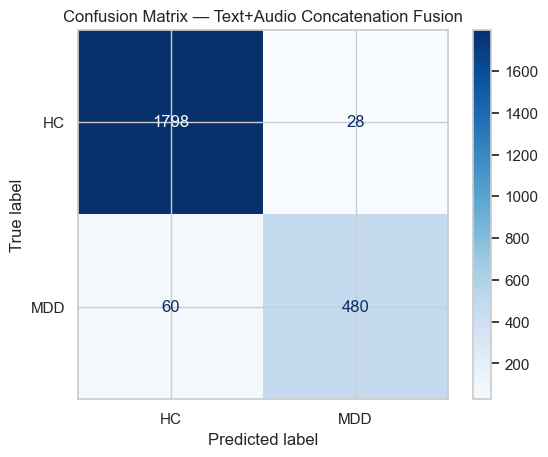

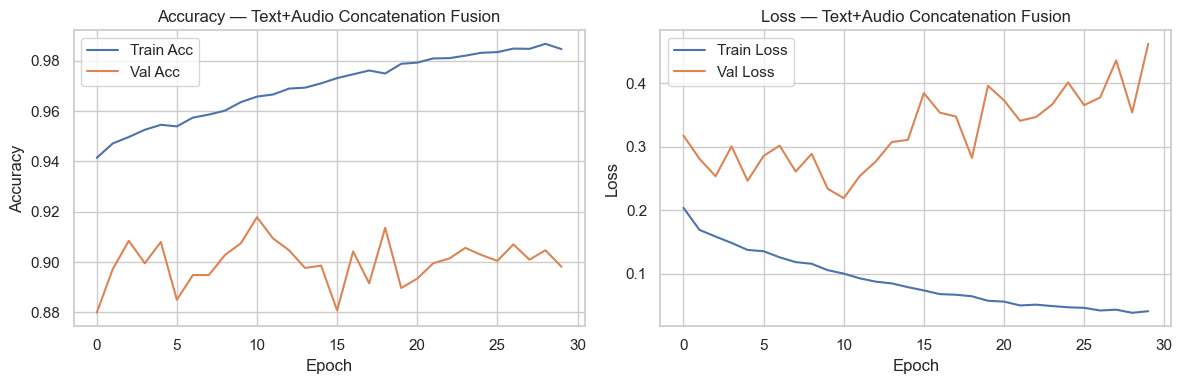

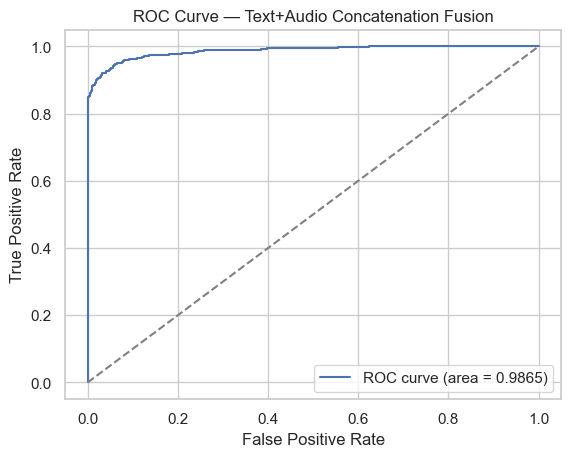

In [22]:
# ================== Concatenation Fusion ==================
model_fusion = build_fusion_model(X_text_train.shape[1:], X_audio_train.shape[1:])
model_fusion.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_fusion = model_fusion.fit([X_text_train, X_audio_train], y_train, validation_split=0.1, epochs=30, batch_size=32, verbose=0)

evaluate_model(
    name="Text+Audio Concatenation Fusion",
    model=model_fusion,
    X_test=None,
    y_test=y_test,
    history=history_fusion,
    y_train=y_train,
    y_val=y_val,
    y_train_final=y_train_final,
    is_fusion=True,
    fusion_inputs=[X_text_test, X_audio_test]
)
